In [1]:
import numpy as np
from qiskit import *

In [2]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

┌──────────┐            
q_0: ┤0         ├────────────
     │  my_gate │┌──────────┐
q_1: ┤1         ├┤0         ├
     └──────────┘│  my_gate │
q_2: ────────────┤1         ├
                 └──────────┘

# Composite Gates¶


In [3]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()

<ipython-input-3-1b85e9df9bff>:8: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  sub_circ.u3(1, 2, -2, sub_q[0])


┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [4]:
decomposed_circ = circ.decompose()
circ1 = transpile(decomposed_circ)
decomposed_circ.draw()

┌─────────┐                                         
q_0: ┤ U2(0,π) ├──■──────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌────────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U3(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬────┘
q_2: ────────────────┤ X ├─────┤ RZ(1) ├─░─────┤ I ├─────
                     └───┘     └───────┘ ░     └───┘

In [5]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(circ, backend)
qc_state = job.result().get_statevector(circ)
qc_state

array([ 0.63083564+0.14346142j,  0.        +0.j        ,
        0.28531987+0.00760246j,  0.        +0.j        ,
        0.        +0.j        ,  0.45574789-0.23911229j,
        0.        +0.j        , -0.48483129+0.00760246j])

# Parameterized circuits

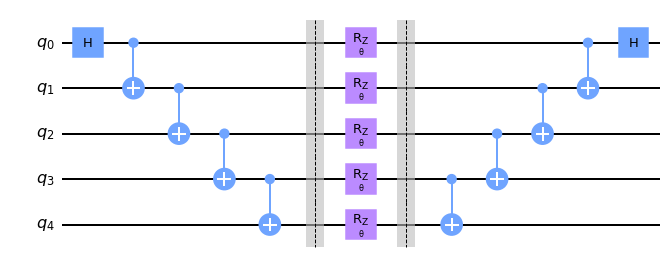

In [6]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)

qc.draw('mpl')

In [7]:
meas = QuantumCircuit(n, 1)
# meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(0, 0)

qc_meas = meas.compose(qc, range(n), front=True)

#drawing the circuit

In [8]:
print(qc_meas.parameters)

ParameterView([Parameter(θ)])


# Binding parameters to values

In [9]:
import numpy as np
theta_range = np.linspace(0, 2 * np.pi, 128)

In [10]:
from qiskit.circuit import Parameter

job = execute(qc_meas,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])

counts = job.result().get_counts()

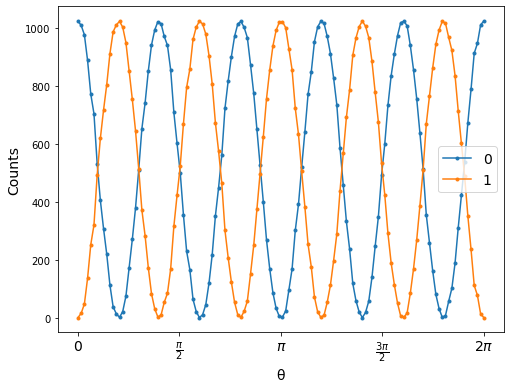

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

# Composition of parameters

In [16]:
phi = Parameter('phi')
phi2 = Parameter('phi2')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])
qc.u3(0.1, phi2, 0.3, 0)

print(qc.draw())

     ┌────────────┐┌────────────┐┌──────────────────┐
q_0: ┤0           ├┤0           ├┤ U3(0.1,phi2,0.3) ├
     │  sc_1(phi) ││  sc_2(phi) │└──────────────────┘
q_1: ┤1           ├┤1           ├────────────────────
     ├────────────┤└────────────┘                    
q_2: ┤0           ├──────────────────────────────────
     │  sc_2(phi) │                                  
q_3: ┤1           ├──────────────────────────────────
     └────────────┘                                  


To insert a subcircuit under a different parameterization, the to_instruction method accepts an optional argument (parameter_map) which, when present, will generate instructions with the source parameter replaced by a new parameter.

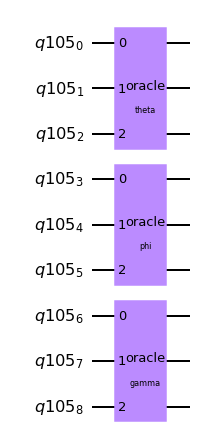

In [45]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
larger_qc.draw('mpl')



In [46]:
n = 9
meas = QuantumCircuit(n, 1)
# meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(0, 0)

qc_meas = meas.compose(larger_qc, range(n), front=True)

In [47]:
theta_range = np.linspace(0,np.pi*2, 128)

In [1]:
from qiskit.circuit import Parameter

job = execute(qc_meas,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val, phi : theta_val, gamma : theta_val} for theta_val in theta_range])

counts = job.result().get_counts()

NameError: name 'execute' is not defined

In [49]:
counts

[{'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0': 1024},
 {'0':